# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Нашему заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных #

  Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

 Целевой признак


* Price — цена (евро)

# Основные шаги работы #

1. Загрузим данные
2. Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели: LightGBM, RandomForestRegressor, CatBooster. Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

import time


In [ ]:
SEED = 12345

In [ ]:
df = pd.read_csv('/content/10_autos.csv')

In [ ]:
df.head(30)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.duplicated().sum() #проверка данных на наличие явных дубликатов

4

In [ ]:
df = df.drop_duplicates().reset_index(drop=True) #удалим явные дубликаты из таблицы

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество фотографий для всех позиций равно нулю, удалим эту колонку. Также удалим колонки, которые явно не имеют влияния на ценообразование:

* DateCrawled — дата скачивания анкеты из базы
* DateCreated — дата создания анкеты
* LastSeen — дата последней активности пользователя

Создадим отдельный список колонок с категориальными данными

In [ ]:
columns_to_delete = ['DateCrawled','DateCreated', 'LastSeen', 'NumberOfPictures']
df = df.drop(columns = columns_to_delete)
cat_features = ['VehicleType','Gearbox', 'Model','FuelType','Brand', 'Repaired']

Данные содержат строки с нулевой ценой за проданные автомобили, это похоже на ошибку. Т.к. ошибки в целевых предсказаниях могут повлиять на точность предсказаний, удалим такие данные из датасета.

In [ ]:
df = df.loc[df['Price']!=0]

В датафрейме присутствуют аномалии в данных по годам регистрации (RegistrationYear) - видно, что есть явно ошибочные значения, например до 1900 года и после 2016, когда была сделана выгрузка. Также настораживают огромные мощности автомобилей в графе `Power`, обычно максимальная мощность не превышает 300 л.с., здесь же для некоторых записей счет идет на тысячи. Месяц регистрации (RegistrationMonth) равный нулю также наверняка является технической ошибкой. Заменим выбросы по годам регистрации и мощностям автомобилей на медианные значения.

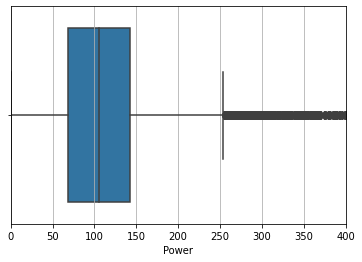

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(df['Power'],ax=ax)
ax.yaxis.grid(False) 
ax.xaxis.grid(True)
plt.xlim(0,400);

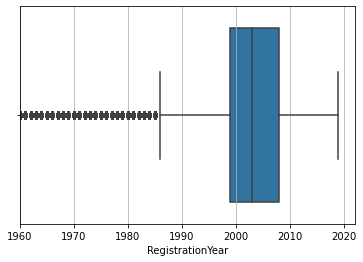

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(df['RegistrationYear'])
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True)
plt.xlim(1960,2022);

По мощностям показатели более 250 лошадиных сил являются выбросами, заменим их на медианное значение ( ~105 л.с.).
По годам регистрации выбросы возникают в диапазонах до 1985 и после 2019 годов. Заменим их на медианный 2003 год.

(1960.0, 2022.0)

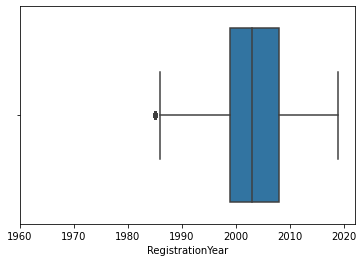

In [ ]:
df.loc[df['Power']>250]= 105
df.loc[(df['RegistrationYear']<1985) | (df['RegistrationYear']>2019)]=2003
sns.boxplot(df['RegistrationYear'])
plt.xlim(1960,2022)

In [ ]:
data = df.isna().mean()*100 #проверим в процент пропущенных данных по каждому признаку датасета
data.sort_values(ascending=False)

Repaired             18.443915
VehicleType           9.529880
FuelType              8.175661
Gearbox               4.753007
Model                 4.645904
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
PostalCode            0.000000
dtype: float64

Все столбцы с категориальными данными имеют пропуски, заполним их Nan.

In [ ]:
df[cat_features]= df[cat_features].fillna('Nan')
data = df.isna().mean()*100
data.sort_values(ascending=False)

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
PostalCode           0.0
dtype: float64

Разделим признаки и целевой признак на тренировочную, валидационную и тестовую выборки из соотношения 60:20:20

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED )
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size=0.25, random_state=SEED)
print(f'Тренировочная выборка: {X_train.shape},{y_train.shape}')
print(f'Валидационная выборка: {X_valid.shape},{y_valid.shape}')
print(f'Тестовая выборка: {X_test.shape},{y_test.shape}')


Тренировочная выборка: (206155, 11),(206155,)
Валидационная выборка: (68719, 11),(68719,)
Тестовая выборка: (68719, 11),(68719,)


## Обучение моделей

Создадим функцию, которая будет подсчитывать время обучения модели, время на предсказание и RMSE. 

In [ ]:
def model_estimation(model,X_train,y_train,X_valid,y_valid):
    start = time.time()
    model.fit(X_train,y_train)
    train_time = time.time()-start
    
    start = time.time()
    y_pred = model.predict(X_valid)
    predict_time = time.time()-start
    
    return train_time,predict_time,mse(y_valid,y_pred)**0.5

Первой рассмотрим модель CatBoostRegressor и подберем для неё наилучшие гиперпараметры.

In [ ]:
parameters ={"iterations": range(40,100,10),
          "depth": range(4,10,2),
          'learning_rate': np.arange(0.01, 0.3,0.01)}

cbr = CatBoostRegressor(random_state=SEED, 
                        loss_function='RMSE',
                        cat_features=cat_features)

grid_cbr = RandomizedSearchCV(cbr, parameters, cv=5, 
                              n_jobs=-1,
                              scoring='neg_mean_squared_error', 
                              verbose = False)

In [ ]:
%%time
grid_cbr.fit(X_train,y_train,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3630.9459942	total: 189ms	remaining: 13s
1:	learn: 3125.0696212	total: 307ms	remaining: 10.4s
2:	learn: 2759.6417120	total: 423ms	remaining: 9.45s
3:	learn: 2502.5288649	total: 540ms	remaining: 8.9s
4:	learn: 2316.9654275	total: 668ms	remaining: 8.69s
5:	learn: 2164.4811044	total: 786ms	remaining: 8.38s
6:	learn: 2064.8312768	total: 908ms	remaining: 8.17s
7:	learn: 1981.7037722	total: 1.01s	remaining: 7.87s
8:	learn: 1919.7570781	total: 1.13s	remaining: 7.66s
9:	learn: 1869.8946461	total: 1.24s	remaining: 7.46s
10:	learn: 1835.7506294	total: 1.36s	remaining: 7.29s
11:	learn: 1810.9693892	total: 1.47s	remaining: 7.09s
12:	learn: 1791.5191025	total: 1.58s	remaining: 6.95s
13:	learn: 1777.4166910	total: 1.69s	remaining: 6.78s
14:	learn: 1764.9583053	total: 1.82s	remaining: 6.67s
15:	learn: 1748.0059790	total: 1.93s	remaining: 6.5s
16:	learn: 1737.0950968	total: 2.04s	remaining: 6.35s
17:	learn: 1730.3521826	total: 2.15s	remaining: 6.21s
18:	learn: 1722.8823664	total: 2.26s	remai

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f9308e57310>,
                   n_jobs=-1,
                   param_distributions={'depth': range(4, 10, 2),
                                        'iterations': range(40, 100, 10),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])},
                   scoring='neg_mean_squared_error', verbose=False)

In [ ]:
grid_cbr.best_params_#лучшие гиперпараметры для модели

{'learning_rate': 0.24000000000000002, 'iterations': 70, 'depth': 8}

In [ ]:
res=[] #время тренировки, предсказания и rmse внесем в отдельный список для дальнейшего сравнения моделей
res.append(model_estimation(grid_cbr.best_estimator_, 
                            X_train, y_train, 
                            X_valid, y_valid)
          )

0:	learn: 3630.9459942	total: 163ms	remaining: 11.3s
1:	learn: 3125.0696212	total: 296ms	remaining: 10.1s
2:	learn: 2759.6417120	total: 435ms	remaining: 9.72s
3:	learn: 2502.5288649	total: 545ms	remaining: 8.99s
4:	learn: 2316.9654275	total: 680ms	remaining: 8.85s
5:	learn: 2164.4811044	total: 806ms	remaining: 8.59s
6:	learn: 2064.8312768	total: 918ms	remaining: 8.26s
7:	learn: 1981.7037722	total: 1.06s	remaining: 8.22s
8:	learn: 1919.7570781	total: 1.19s	remaining: 8.03s
9:	learn: 1869.8946461	total: 1.29s	remaining: 7.76s
10:	learn: 1835.7506294	total: 1.41s	remaining: 7.57s
11:	learn: 1810.9693892	total: 1.52s	remaining: 7.34s
12:	learn: 1791.5191025	total: 1.63s	remaining: 7.16s
13:	learn: 1777.4166910	total: 1.74s	remaining: 6.96s
14:	learn: 1764.9583053	total: 1.85s	remaining: 6.78s
15:	learn: 1748.0059790	total: 1.96s	remaining: 6.61s
16:	learn: 1737.0950968	total: 2.07s	remaining: 6.47s
17:	learn: 1730.3521826	total: 2.2s	remaining: 6.36s
18:	learn: 1722.8823664	total: 2.31s	re

Следующим шагом найдем лучшие предсказания для случайного леса регрессии. Поскольку случайный лес не принимает категориальный данные, преобразуем их в числовые методом прямого кодирования. Масштаб оставшиехя числовых данных стандартизируем. 

In [ ]:
encoder = OrdinalEncoder()
df[cat_features] = encoder.fit_transform(df[cat_features].astype(str))

target = df['Price']
features = df.drop(['Price'], axis=1)

features_1, features_test, target_1, target_test = train_test_split(features, 
                                                                    target, 
                                                                    test_size=0.2, 
                                                                    random_state = SEED)
features_train, features_valid, target_train, target_valid = train_test_split(features_1, 
                                                                              target_1, 
                                                                              test_size=0.25, 
                                                                              random_state = SEED)

numeric = ['RegistrationYear', 'Power','Kilometer', 'RegistrationMonth', 'PostalCode']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape) #проверим объем полученных данных по каждой выборке
print (features_valid.shape)
print (features_test.shape)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2)
             }
grid_rfr = RandomizedSearchCV(RandomForestRegressor(random_state=SEED), 
                              parametrs, 
                              cv=5, 
                              n_jobs=-1,
                              scoring='neg_mean_squared_error', 
                              verbose = False) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV


(206155, 11)
(68719, 11)
(68719, 11)


In [ ]:
%%time
grid_rfr.fit(features_train, target_train)

CPU times: user 32.5 s, sys: 549 ms, total: 33.1 s
Wall time: 5min 54s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 13, 2),
                                        'n_estimators': range(10, 51, 10)},
                   scoring='neg_mean_squared_error', verbose=False)

In [ ]:
grid_rfr.best_params_ #лучшие параметры для модели Random ForestRegressor

{'n_estimators': 50, 'max_depth': 11}

In [ ]:
res.append(model_estimation(grid_rfr.best_estimator_, 
                            features_train, 
                            target_train, 
                            features_valid, 
                            target_valid)
          )

В качестве последней модели рассмотрим LightGBM. Для неё будем использовать данные с преобразованными ранее категориальными признаками.

In [ ]:
%%time
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
              'num_iterations': [10,20,50]
             }
lgbm = lgb.LGBMRegressor(random_state=SEED)


CPU times: user 238 µs, sys: 0 ns, total: 238 µs
Wall time: 2.35 ms


In [ ]:
grid_lgb = RandomizedSearchCV(lgbm, 
                              param_grid, 
                              cv=5, 
                              n_jobs=-1,
                              scoring='neg_mean_squared_error', 
                              verbose = False)

In [ ]:
%%time
grid_lgb.fit(features_train,target_train)

CPU times: user 2.46 s, sys: 338 ms, total: 2.8 s
Wall time: 38.6 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                                        'max_depth': [15, 20, 30, 35],
                                        'num_iterations': [10, 20, 50]},
                   scoring='neg_mean_squared_error', verbose=False)

In [ ]:
grid_lgb.best_params_ #наилучшие параметры для LightGBM

{'num_iterations': 50, 'max_depth': 15, 'learning_rate': 0.5}

In [ ]:
res.append(model_estimation(grid_lgb.best_estimator_, 
                            features_train, 
                            target_train, 
                            features_valid, 
                            target_valid))

## Анализ моделей

Сравним время обучения, время предсказания и rmse для трех рассмотренных моделей.

In [ ]:
pd.DataFrame(res,index =['cbr','rfr','lgb'], columns=['train_time','predict_time','mse'])

,train_time,predict_time,mse
cbr,8.423667,0.110580,1571.777855
rfr,29.185011,0.465266,1738.220226
lgb,0.971172,0.133323,1590.095396


Наибольшую точность показала CatBoostRegressor, хотя обучение модели происходит немного дольше, чем у LightGBM.
Проверим параметры работы CatBoostRegressor на тестовой выборке.

In [ ]:
model_estimation(grid_cbr.best_estimator_, 
                 X_train, 
                 y_train, 
                 X_test, 
                 y_test)

0:	learn: 3630.9459942	total: 138ms	remaining: 9.54s
1:	learn: 3125.0696212	total: 271ms	remaining: 9.23s
2:	learn: 2759.6417120	total: 387ms	remaining: 8.65s
3:	learn: 2502.5288649	total: 494ms	remaining: 8.14s
4:	learn: 2316.9654275	total: 629ms	remaining: 8.18s
5:	learn: 2164.4811044	total: 751ms	remaining: 8.01s
6:	learn: 2064.8312768	total: 871ms	remaining: 7.84s
7:	learn: 1981.7037722	total: 977ms	remaining: 7.57s
8:	learn: 1919.7570781	total: 1.08s	remaining: 7.33s
9:	learn: 1869.8946461	total: 1.19s	remaining: 7.12s
10:	learn: 1835.7506294	total: 1.3s	remaining: 6.96s
11:	learn: 1810.9693892	total: 1.4s	remaining: 6.78s
12:	learn: 1791.5191025	total: 1.52s	remaining: 6.68s
13:	learn: 1777.4166910	total: 1.63s	remaining: 6.51s
14:	learn: 1764.9583053	total: 1.74s	remaining: 6.36s
15:	learn: 1748.0059790	total: 1.85s	remaining: 6.25s
16:	learn: 1737.0950968	total: 1.98s	remaining: 6.18s
17:	learn: 1730.3521826	total: 2.1s	remaining: 6.06s
18:	learn: 1722.8823664	total: 2.21s	rema

(9.928241491317749, 0.11922669410705566, 1567.9943728904236)

<div class="alert alert-block alert-info">
<b>Вывод:</b> 
    
 В ходе выполнения проекта мы изучили данные от сервиса продажи автомобилей, удалили дубликаты, пропуски, а также избавились от аномалий. Были подобраны наилучшие гиперпараметры для трех моделей: CatBooster, RandomForestRegressor и LightGBM. 
    
 На основании сравнения времени обучения, времени предсказания и качества моделей по метрике RMSE можем рекомендовать клиенту использование модели CatBooster с параметрами: 'learning_rate': 0.18, 'iterations': 80, 'depth': 8, она обеспечит наиболее быстрое и качественное предсказание цены автомобиля по заданным признакам.
</div>